#### *Bringing necessary libraries*

In [1]:
from __future__ import print_function, division

import torch
import argparse
import json 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from functools import partial 
import time
import os
import random
import copy
import pdb 
from tqdm import tqdm
from _utils import accuracy
import matplotlib.pyplot as plt

#### *Transforming images to tensor and normalizing them* 

In [2]:
def transfrom_data():
    data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])
    }

    return data_transforms

#### *Loading test images by batches*

In [3]:
def load_data(batch_size, num_workers):
    print("Start loading data")
    data_dir = '../data'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transfrom_data()[x]) for x in ['test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) \
                    for x in ['test']}
    class_names = image_datasets['test'].classes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
    print("Dataset sizes: Test {}".format(dataset_sizes['test']))
    print("Number of classes: Test {}".format(len(image_datasets['test'].classes)))

    return dataloaders, class_names, dataset_sizes

#### *Loading the model to use the best epoch results from training*

In [4]:
def load_model(class_names):
    #Loading the best epoch weights
    state_dict = torch.load('outputs/best_val_model_sharpen_9067.ft')
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model = models.densenet161(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 196)
    model.load_state_dict(new_state_dict) 
    return model

In [5]:
dataloaders, class_names, dataset_sizes = load_data(5, 12)
model= load_model(class_names)
model.cuda()
best_test_top1_acc = 0.0
best_test_epoch = -1
final_test_top5_acc = 0.0 

model.eval()

running_loss = 0.0
top1_running_corrects = 0
top5_running_corrects = 0

phase='test'
it = tqdm(range(len(dataloaders[phase])))
data_iter = iter(dataloaders[phase])

pred = []
true = []

for niter in it:
    inputs, labels = data_iter.next()
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    
    _, preds = torch.max(outputs,1)    
    pred.append(preds)
    true.append(labels)
    
    prec1, prec5 = accuracy(outputs, labels, topk=(1,5))
    
    top1_running_corrects += prec1[0]
    top5_running_corrects += prec5[0]
    
top1_epoch_acc = float(top1_running_corrects) / dataset_sizes[phase]
top5_epoch_acc = float(top5_running_corrects) / dataset_sizes[phase]

print('{} Epoch top1 Acc: {:.6f} Epoch top5 Acc: {:.6f}\n'.format(phase,top1_epoch_acc, top5_epoch_acc))

Start loading data
Dataset sizes: Test 8041
Number of classes: Test 196


100%|██████████████████████████████████████████████████████████████████████████████| 1609/1609 [01:49<00:00, 14.73it/s]


test Epoch top1 Acc: 0.902375 Epoch top5 Acc: 0.984330



### Consfusion Matrix, Precision, Recall, Accuracy

In [6]:
#Transforming tensor to numpy format in CPU
true = torch.cat(true).cpu()
pred = torch.cat(pred).cpu()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def performance_matrix(true,pred):
    precision = precision_score(true,pred,average='macro')
    recall = recall_score(true,pred,average='macro')
    accuracy = accuracy_score(true,pred)
    print('Confusion Matrix:\n',confusion_matrix(true, pred),'\n')
    print('Precision: {:.2f}, Recall: {:.2f}, Accuracy: {:.2f}'.format(precision*100,recall*100,accuracy*100))

In [8]:
performance_matrix(true,pred)

Confusion Matrix:
 [[44  0  0 ...  0  0  0]
 [ 0 28  3 ...  0  0  0]
 [ 0  1 42 ...  0  0  0]
 ...
 [ 0  0  0 ... 43  0  0]
 [ 0  0  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 39]] 

Precision: 90.52, Recall: 90.19, Accuracy: 90.24


#### Plotting Confusion Matrix Results

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    plt.style.use('ggplot')
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('winter')

    plt.figure(figsize=(50, 40))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [10]:
cnf_matrix = confusion_matrix(true, pred)

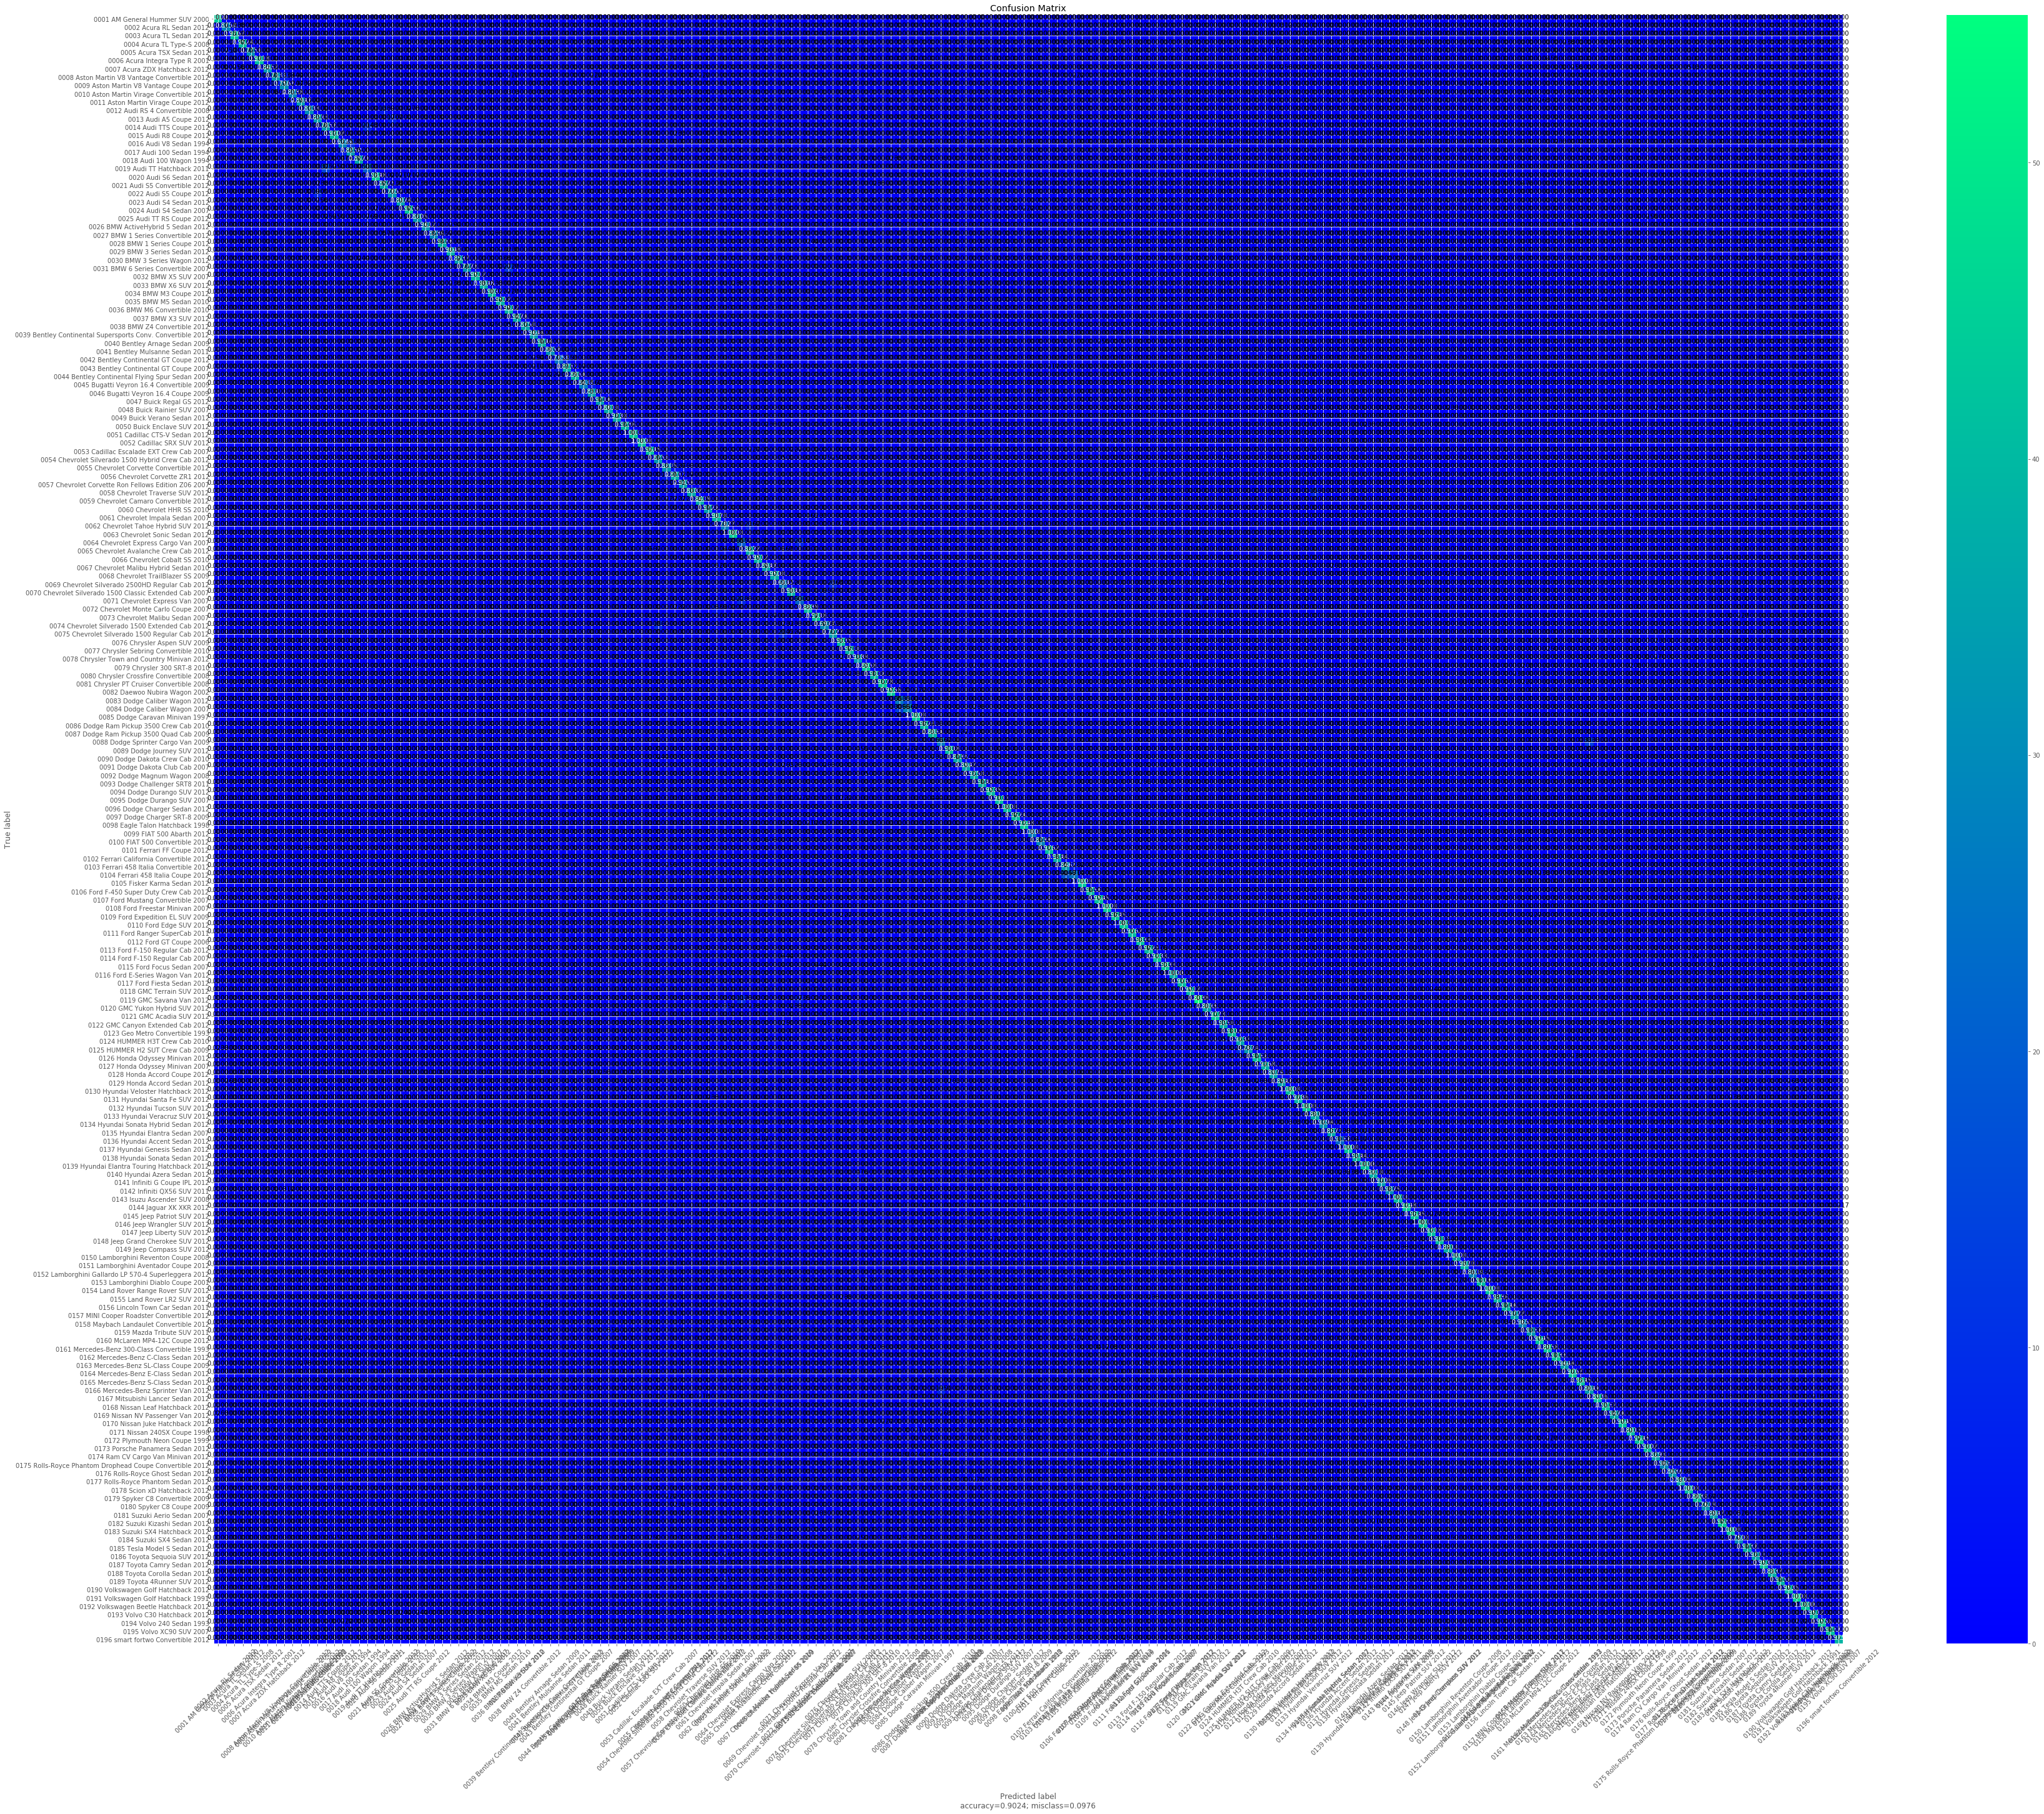

In [11]:
plot_confusion_matrix(cm= cnf_matrix, 
                      normalize    = True,
                      target_names = class_names,
                      title        = "Confusion Matrix")

#### *Function for visualization the prediction results*

In [18]:
%matplotlib inline

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            
            sm = torch.nn.Softmax(dim=1)
            probs = sm(outputs)
            prob,_ = torch.max(probs,1)
            
            _, preds = torch.max(outputs,1)    

            for j in range(inputs.size()[0]):
                
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {} | {:.2f}%'.format(class_names[preds[j]], 100*prob[j]))
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

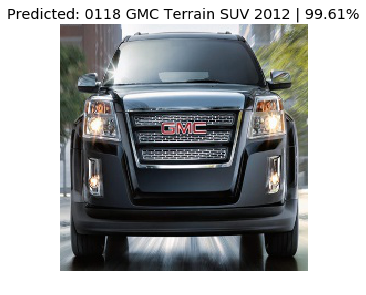

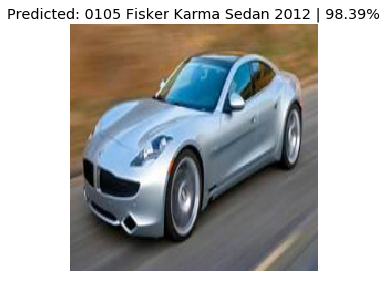

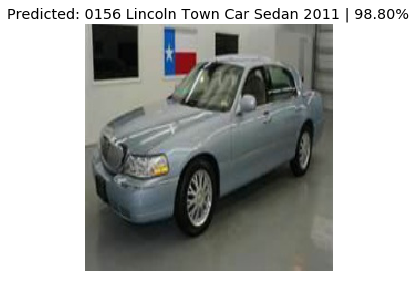

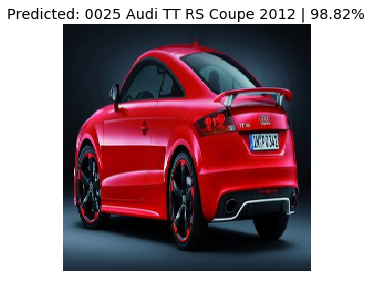

In [20]:
visualize_model(model)

plt.ioff()
plt.show()